# South African Language Identification Hack 2022
***EDSA 2201 classification hackathon***

**James Beta**

This notebook serves as the workspace for the hackathon submitted on kaggle.

The notebook is ordered as follows;
1. Imports
2. Exploratory Data Analysis
3. Data Cleaning and Feature Engineering
4. Model Building and Evaluation

## Imports

We will begin by importing all necessary packages to explore the data, clean out unwante features, create relevant features and build a model.

In [16]:
import pandas as pd
import numpy as np
import string
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

In [2]:
df_train = pd.read_csv('train_set.csv')
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


## Exploratory Data Analysis

In this section we explore our data by applying non-technical analysis to understand the structure and contents of our dataset

In [3]:
df_train.shape

(33000, 2)

In [4]:
df_train.info

<bound method DataFrame.info of       lang_id                                               text
0         xho  umgaqo-siseko wenza amalungiselelo kumaziko ax...
1         xho  i-dha iya kuba nobulumko bokubeka umsebenzi na...
2         eng  the province of kwazulu-natal department of tr...
3         nso  o netefatša gore o ba file dilo ka moka tše le...
4         ven  khomishini ya ndinganyiso ya mbeu yo ewa maana...
...       ...                                                ...
32995     tsn  popo ya dipolateforomo tse ke go tlisa boetele...
32996     sot  modise mosadi na o ntse o sa utlwe hore thaban...
32997     eng  closing date for the submission of completed t...
32998     xho  nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999     sot  mafapha a mang le ona a lokela ho etsa ditlale...

[33000 rows x 2 columns]>

In [5]:
def clean_title(title): 
    title = re.sub('<.*?>', ' ', title)
    #pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+' #Pattern to remove all hyperlinks
    #title = re.sub(pattern_url,' ',title)    
    #title = re.sub('RT @.*:','',title)    
    title = re.sub('[^a-zA-Z#]', ' ',title) 
    #title = re.sub(r'(\s)#\w+','',title)  
    title = title.lower()
    title = ' '.join(title.split())
    return title

In [6]:
df_train['cleaned_message'] = df_train['text'].apply(clean_title)
df_train

,lang_id,text,cleaned_message
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,i dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulu natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefat a gore o ba file dilo ka moka t e le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...
...,...,...,...
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...,nawuphina umntu ofunyenwe enetyala phantsi kwa...


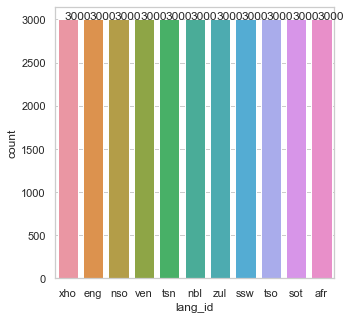

In [7]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(x=df_train['lang_id'],  data=df_train, order = df_train['lang_id'].value_counts().index )
for p, label in zip(ax.patches, df_train['lang_id'].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

## Data Cleaning and Feature Engineering

now that we understand what the dataset contains, proceed to prepare the data for modelling by removing all unwanted/ unnecessary information and working on transforming the data into a useful format ready for the next stage which is model building.

In [8]:
# vect = CountVectorizer()
# X_count = vect.fit_transform(df_train['cleaned_message'].values.astype(str))
vect_20 = CountVectorizer(lowercase=True, max_features = 11000)
X_count = vect_20.fit_transform(df_train['cleaned_message'].values.astype(str))
X_count.shape
X = vect_20.fit_transform(df_train['cleaned_message'].values).toarray()

In [9]:
x = df_train['cleaned_message']
y = df_train['lang_id']
# vectorization clean training data 
vectorizer = TfidfVectorizer(min_df=2,  max_df=0.9,
                             ngram_range=(3, 6), analyzer=('char'))
features = vectorizer.fit_transform(x)
labels = df_train['lang_id']

# Fit label encoder and return encoded labels
le = LabelEncoder()
Y = le.fit_transform(y)
# List of label encoder types to use for lookup 
type_labels = list(le.classes_)



In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, Y,test_size=0.2, random_state = 42)

## Model Building and Evaluation

In this section we use the features extracted from our data to build our classification model.
The model is then assesed based on its ability to classify the test data by identifying the language a tweet is written in. 

In [11]:
lm_kbest = LogisticRegression(random_state = 42, multi_class='ovr', n_jobs = 1, C = 1e5, max_iter = 4000)
# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=5000)

# Transform the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)
# Fit model to the transformed data
lm_kbest.fit(X_train_kbest, y_train)
X_test_kbest = selector_kbest.transform(X_test)


C:\Users\kinyabeta\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kinyabeta\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [12]:
df_test = pd.read_csv('test_set.csv')
df_test['cleaned_message'] = df_test['text'].apply(clean_title)

test_features = vectorizer.transform(df_test.cleaned_message)
test_features = selector_kbest.transform(test_features)
new_pred = lm_kbest.predict(test_features)

df_test['lang_id'] = list(le.inverse_transform(new_pred))
sub = df_test[['index','lang_id']]
sub = sub.set_index('index')
sub.to_csv('Submission16.csv')

C:\Users\kinyabeta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


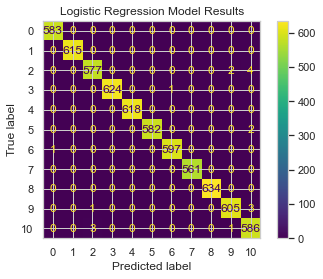

In [13]:
plot_confusion_matrix(lm_kbest, selector_kbest.transform(X_test), y_test)  
figsize=(10, 10)
plt.title('Logistic Regression Model Results')
plt.show()


In [14]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [20]:
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

In [21]:
df_test = pd.read_csv('test_set.csv')
df_test['cleaned_message'] = df_test['text'].apply(clean_title)

test_features = vectorizer.transform(df_test.text)
new_pred1 = model.predict(test_features)

df_test['lang_id'] = list(le.inverse_transform(new_pred1))
# df_test.rename(columns={'pred':'lang_id'},inplace=True)
sub = df_test[['index','lang_id']]
sub = sub.set_index('index')
sub.to_csv('Submission17.csv')

C:\Users\kinyabeta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


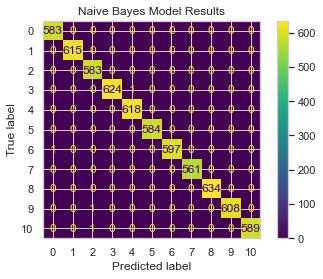

In [25]:

ypred1 = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)  
figsize=(10, 10)

plt.title('Naive Bayes Model Results')

plt.show()

In [ ]:
#Logistic regression model for training 
lm_model = LogisticRegression(random_state = 42, multi_class='ovr', n_jobs = 1, C = 1e5, max_iter = 4000)
lm_model.fit(X_train, y_train)


In [ ]:
df_test = pd.read_csv('test_set.csv')
df_test['cleaned_message'] = df_test['text'].apply(clean_title)
test_features = vectorizer.transform(df_test.cleaned_message)
new_pred2 = lm_model.predict(test_features)

df_test['lang_id'] = list(le.inverse_transform(new_pred2))
# df_test.rename(columns={'pred':'lang_id'},inplace=True)
sub = df_test[['index','lang_id']]
sub = sub.set_index('index')
sub.to_csv('Submission18.csv')

In [ ]:
ypred2 = lm_model.predict(X_test)
plot_confusion_matrix(lm_model, X_test, y_test)
figsize=(10, 10)
plt.title('Logistic Regression Model (Kbest) Results')

plt.show()

In [ ]:
svm_model = LinearSVC(penalty='l2',multi_class='ovr')
svm_model.fit(X_train, y_train)

df_test = pd.read_csv('test_set.csv')
df_test['cleaned_message'] = df_test['text'].apply(clean_title)
test_features = vectorizer.transform(df_test.cleaned_message)
new_pred3 = svm_model.predict(test_features)
df_test['lang_id'] = list(le.inverse_transform(new_pred3))

In [ ]:
# df_test.rename(columns={'pred':'lang_id'},inplace=True)
sub = df_test[['index','lang_id']]
sub = sub.set_index('index')
sub.to_csv('Submission19.csv')

In [ ]:
ypred3 = svm_model.predict(X_test)
plot_confusion_matrix(svm_model, X_test, y_test)
figsize=(10, 10)
plt.title('Support Vector Classifier Results')
plt.show()

In [ ]:
model_names = ['Logistic Regression', 'Logistic regression with K-best features', 'Naive Bayes',  'Linear SVC']
model_list = [lm_model, lm_kbest, model, svm_model]

In [ ]:
Testing_performance = []
Training_performance = []
for x in model_list:
    if x == lm_kbest:
        Training_performances = x.score(X_train_kbest, y_train)
        Training_performance.append(Training_performances)
        Testing_performances = x.score(X_test_kbest, y_test)
        Testing_performance.append(Testing_performances)
    else:
        Training_performances = x.score(X_train, y_train)
        Training_performance.append(Training_performances)
        Testing_performances = x.score(X_test, y_test)
        Testing_performance.append(Testing_performances)
dict1 = {'Model': model_names, 'Training Performance': Training_performance, 'Testing Performance': Testing_performance}
Model_df = pd.DataFrame(dict1)
Model_df

In [ ]:

plt.figure(figsize=(15, 15))

x = np.arange(len(model_names))
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(15,15))
rects1 = ax.bar(x - width/2, Training_performance, width, label='Training Performance')
rects2 = ax.bar(x + width/2, Training_performance, width, label='Testing Performance')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Performance')
ax.set_xlabel('Models')
ax.set_title('Performance on Training and Test Sets')
ax.set_xticks(x, model_names)
box = ax.get_position()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# fig.tight_layout()

plt.show()